<a href="https://colab.research.google.com/github/saja30/-Prediction-of-Product-Sales-/blob/main/Project_1_Part_8_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [26]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Import modeling tools
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
# set the default output to pandas
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )
  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

# reading Data

In [28]:
file_path=("/content/drive/MyDrive/assignment/sales_predictions_2023 (1).csv")
df=pd.read_csv(file_path)
pd.set_option("display.max_columns",100)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# check duplicated

In [29]:
row_duplicates=df.duplicated().sum()
print(row_duplicates)

0


# Fix inconsistencies

In [30]:
df['Item_Fat_Content']=df['Item_Fat_Content'].replace({"LF":"Low Fat","low fat":"Low Fat","reg":"Regular"})
df['Item_Fat_Content'].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

# Identifing Data

In [31]:
y=df["Item_Outlet_Sales"]
X=df.drop(columns=["Item_Outlet_Sales","Item_Identifier"])

# Spliting Data

In [32]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)
X_train.head().round(2)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.35,Low Fat,0.03,Household,256.46,OUT018,2009,Medium,Tier 3,Supermarket Type2
7510,15.25,Regular,0.00,Snack Foods,179.77,OUT018,2009,Medium,Tier 3,Supermarket Type2
5828,12.35,Regular,0.16,Meat,157.29,OUT049,1999,Medium,Tier 1,Supermarket Type1
5327,7.98,Low Fat,0.01,Baking Goods,82.32,OUT035,2004,Small,Tier 2,Supermarket Type1
4810,19.35,Low Fat,0.02,Frozen Foods,120.91,OUT045,2002,NaN,Tier 2,Supermarket Type1


# Numeric , Categorical, Ordinal features

In [33]:
num_cols=X_train.select_dtypes("number").columns
num_cols


Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')

In [34]:
ord_cols=["Outlet_Size"]
ord_cols

['Outlet_Size']

In [35]:
cat_cols=X_train.select_dtypes("object").drop(columns="Outlet_Size").columns
cat_cols

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

# Create a preprocessing object to prepare the dataset for Machine Learning

In [36]:
X_train.describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,5285.00,6392.00,6392.00,6392.00
mean,12.90,0.07,141.98,1997.86
std,4.64,0.05,62.63,8.39
min,4.56,0.00,31.29,1985.00
25%,8.90,0.03,94.15,1987.00
50%,12.65,0.05,144.11,1999.00
75%,17.00,0.09,186.90,2004.00
max,21.35,0.33,266.89,2009.00


# checking for null values in numeric columns

In [37]:
null_count=X_train[num_cols].isna().sum()
null_count

Item_Weight                  1107
Item_Visibility                 0
Item_MRP                        0
Outlet_Establishment_Year       0
dtype: int64

In [38]:
impute_mean=SimpleImputer(strategy="mean")
Scaler=StandardScaler()
num_pipe=make_pipeline(impute_mean,Scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

# checking for null values in object columns columns

In [39]:
X_train[cat_cols].isna().sum()

Item_Fat_Content        0
Item_Type               0
Outlet_Identifier       0
Outlet_Location_Type    0
Outlet_Type             0
dtype: int64

In [40]:
X_test[ord_cols].isna().sum()

Outlet_Size    598
dtype: int64

In [41]:
Otlet_size_ord=["NA","Small","Medium","High"]
ordinal_category_orders=[Otlet_size_ord]
odr_encoder=OrdinalEncoder(categories=ordinal_category_orders)
impute_na_ord=SimpleImputer(strategy="constant",fill_value="NA")
scaler_ord=StandardScaler()
Ohe_encoder=OneHotEncoder(drop="first",sparse=False)
ord_pipe=make_pipeline(impute_na_ord,odr_encoder,scaler_ord)
ord_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='NA', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['NA', 'Small', 'Medium',
                                             'High']])),
                ('standardscaler', StandardScaler())])

In [42]:
cat_pipe=make_pipeline(Ohe_encoder)
cat_pipe

Pipeline(steps=[('onehotencoder', OneHotEncoder(drop='first', sparse=False))])

In [43]:
num_tuple=("numeric",num_pipe,num_cols)
ord_tuple=("ordinal",ord_pipe,ord_cols)
cat_tuple=("categorical",cat_pipe,cat_cols)

# Instantiate the Column Transformer

In [44]:
preprocessor=ColumnTransformer([num_tuple,ord_tuple,cat_tuple],verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['NA',
                                                                              'Small',
                                                                              'Medium',
                                                                              'High']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [45]:
preprocessor.fit(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['NA',
                                                                              'Small',
                                                                              'Medium',
                                                                              'High']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [49]:
features_names=preprocessor.get_feature_names_out()
features_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Outlet_Size',
       'Item_Fat_Content_Regular', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3'

In [50]:
X_train_tf=pd.DataFrame(preprocessor.transform(X_train),columns=features_names,index=X_train.index)
X_test_tf=pd.DataFrame(preprocessor.transform(X_test),columns=features_names,index=X_test.index)
X_train_tf.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,0.817249,-0.712775,1.828109,1.327849,0.748125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7510,0.556340,-1.291052,0.603369,1.327849,0.748125,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5828,-0.131512,1.813319,0.244541,0.136187,0.748125,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Instantiate LinearRegression

In [67]:
lin_reg=LinearRegression()
lin_reg.fit(X_train_tf,y_train)

LinearRegression()

In [68]:
evaluate_regression(lin_reg,X_train_tf,y_train,X_test_tf,y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.129
- MSE = 1,297,558.136
- RMSE = 1,139.104
- R^2 = 0.562

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.120
- MSE = 1,194,349.715
- RMSE = 1,092.863
- R^2 = 0.567


# extract coefficients

In [57]:
# saving coefficients
coeffs=pd.Series(lin_reg.coef_,index=lin_reg.feature_names_in_)
coeffs["intercept"]=lin_reg.intercept_
coeffs
coeffs

Item_Weight                          -8.186752
Item_Visibility                     -21.646473
Item_MRP                            984.513074
Outlet_Establishment_Year           168.214921
Outlet_Size                         664.210506
Item_Fat_Content_Regular             62.625234
Item_Type_Breads                    -28.648318
Item_Type_Breakfast                  45.361064
Item_Type_Canned                     27.516194
Item_Type_Dairy                    -106.335014
Item_Type_Frozen Foods               -1.770626
Item_Type_Fruits and Vegetables      45.754029
Item_Type_Hard Drinks                13.894899
Item_Type_Health and Hygiene         27.025414
Item_Type_Household                   5.509746
Item_Type_Meat                      -11.864887
Item_Type_Others                    -26.813726
Item_Type_Seafood                   327.501136
Item_Type_Snack Foods               -21.932393
Item_Type_Soft Drinks               -39.485735
Item_Type_Starchy Foods              42.088865
Outlet_Identi

# visualize the coefficients

In [59]:
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:

        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

In [60]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5),
                intercept=False, intercept_name="intercept",
                annotate=False, ha='left', va='center', size=12,
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)

        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient',
            ylabel='Feature Names',
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax

<Axes: title={'center': 'Top 3 Largest Coefficients'}, xlabel='Coefficient', ylabel='Feature Names'>

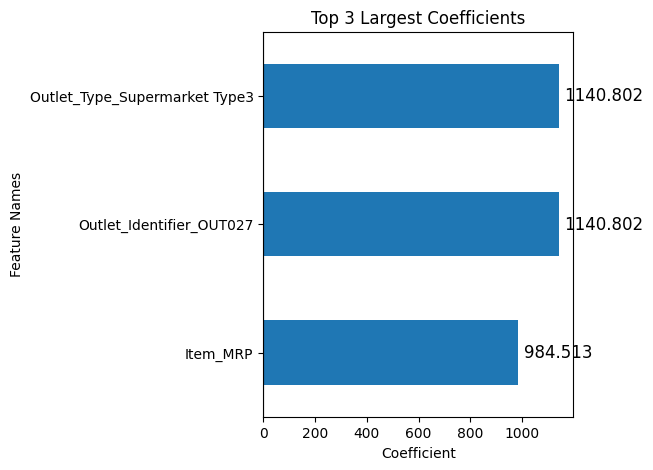

In [66]:
plot_coeffs(coeffs, top_n=3,annotate=True)

## Outlet_Type_Supermarket Type3=1140.802
*if outlet_type _supermarket tend to be in type three(3) , the model predicted outlet_supermarket_type3 Sales increased by 1140 $

---




## Outlet_Identifier_OUT027=1140.802
*if outlet_identifier tend to be in OUT027 , the model predicted Sales for OUT027 increased by 1140$ *

---


## Item_MRP =984.513
*for every 1 $ increased in Item_MRP the model predicted Sales increased 984 $*

# Tree-Based Model

In [69]:
rf=RandomForestRegressor(random_state=42)
rf.fit(X_train_tf,y_train)

RandomForestRegressor(random_state=42)

In [71]:
feature_importance=pd.Series(rf.feature_importances_,index=X_train_tf.columns,name="RFfeature Importance")
feature_importance


Item_Weight                        0.056967
Item_Visibility                    0.100116
Item_MRP                           0.444662
Outlet_Establishment_Year          0.030174
Outlet_Size                        0.022953
Item_Fat_Content_Regular           0.009180
Item_Type_Breads                   0.002617
Item_Type_Breakfast                0.002615
Item_Type_Canned                   0.004354
Item_Type_Dairy                    0.006270
Item_Type_Frozen Foods             0.006150
Item_Type_Fruits and Vegetables    0.008044
Item_Type_Hard Drinks              0.003041
Item_Type_Health and Hygiene       0.004186
Item_Type_Household                0.006787
Item_Type_Meat                     0.003718
Item_Type_Others                   0.001720
Item_Type_Seafood                  0.001857
Item_Type_Snack Foods              0.008473
Item_Type_Soft Drinks              0.005465
Item_Type_Starchy Foods            0.003558
Outlet_Identifier_OUT013           0.001656
Outlet_Identifier_OUT017        

[Text(0.5, 0, 'Feature Importance'), Text(0, 0.5, 'Feature Names')]

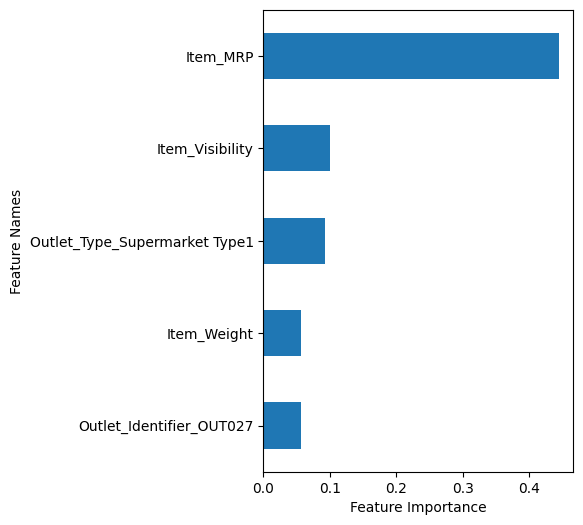

In [72]:
ax=feature_importance.sort_values().tail(5).plot(kind="barh",figsize=(4,6))
ax.set(xlabel="Feature Importance",ylabel="Feature Names")

## we see tha the top five features importance are

1.   Item_MRP
2.   Item_Visibility
3.   Outlet_Type_Supermarket Type1
4. Item_Weight
5. Outlet_Identifier_OUT027




#  recommendations to your stakeholder.
 *i recommended to takecare of ITEM_MPR since it is very important and its coefficient is very high*